In [1]:
import geopandas as gpd
import shapely
from geovoronoi import voronoi_regions_from_coords
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
import random
from shapely.geometry import Point
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
# %load_ext autoreload
# %autoreload 2

In [3]:
import split_blocks as sb

# Load the DC `squares` (I think of them as city blocks)

In [4]:
squares = gpd.read_file("gis_data/Square_Boundaries-shp/")

In [5]:
squares.head(3)

,OBJECTID,GIS_ID,CREATION_D,RECORDATIO,NARRATIVE,EXPIRATION,STATUS,SQUARE,SUFFIX,COMPUTED_A,...,SQUAREPLYI,FIT_ROTATI,FIT_ROTA_1,FIT_ROTA_2,SW_CORNER_,SW_CORNE_1,KILL_DT,SHAPEAREA,SHAPELEN,geometry
0,2717682,1174138.0,2006-09-09,1970-01-01,DELIVERY 12,1970-01-01,1,6239,S,401844,...,None,NaN,NaN,NaN,NaN,NaN,1970-01-01,37332.666173,1167.603867,"POLYGON ((-77.00694 38.82504, -77.00632 38.824..."
1,2717683,1177508.0,2006-09-09,1970-01-01,DELIVERY 6,1970-01-01,1,1303,None,105420,...,None,NaN,NaN,NaN,NaN,NaN,1970-01-01,9793.879221,438.912894,"POLYGON ((-77.06988 38.91432, -77.06987 38.914..."
2,2717684,1173503.0,2006-09-09,1970-01-01,DELIVERY 12,1970-01-01,1,5521,None,157309,...,None,NaN,NaN,NaN,NaN,NaN,1970-01-01,14614.509037,550.917664,"POLYGON ((-76.94705 38.86496, -76.94705 38.864..."


# load `address_pts`

In [6]:
addresses = gpd.read_file("gis_data/Address_Points-shp/")

In [7]:
addresses.shape

(148157, 59)

In [8]:
addresses.head(3)

,OBJECTID_1,OBJECTID,SITE_ADDRE,ADDRESS_ID,ROADWAYSEG,STATUS,SSL,TYPE_,ENTRANCETY,ADDRNUM,...,ACTIVE_RES,RES_TYPE,ACTIVE_R_1,WARD_2002,WARD_2012,ANC_2002,ANC_2012,SMD_2002,SMD_2012,geometry
0,832017,1087.0,27746,27746,11690.0,ACTIVE,0814 0018,ADDRESS,OFFICIAL,402.0,...,0.0,RESIDENTIAL,1.0,Ward 6,Ward 6,ANC 6C,ANC 6C,SMD 6C07,SMD 6C03,POINT (-77.00035 38.89220)
1,832018,3265.0,50808,50808,3073.0,ACTIVE,0838 0027,ADDRESS,OFFICIAL,219.0,...,0.0,RESIDENTIAL,1.0,Ward 6,Ward 6,ANC 6C,ANC 6C,SMD 6C07,SMD 6C03,POINT (-76.99925 38.89265)
2,832019,3266.0,51065,51065,3073.0,ACTIVE,0814 0818,ADDRESS,OFFICIAL,216.0,...,1.0,RESIDENTIAL,2.0,Ward 6,Ward 6,ANC 6C,ANC 6C,SMD 6C07,SMD 6C03,POINT (-76.99977 38.89256)


In [9]:
addresses.iloc[0]

OBJECTID_1                                              832017
OBJECTID                                                  1087
SITE_ADDRE                                               27746
ADDRESS_ID                                               27746
ROADWAYSEG                                               11690
STATUS                                                  ACTIVE
SSL                                               0814    0018
TYPE_                                                  ADDRESS
ENTRANCETY                                            OFFICIAL
ADDRNUM                                                    402
ADDRNUMSUF                                                None
STNAME                                            CONSTITUTION
STREET_TYP                                              AVENUE
QUADRANT                                                    NE
CITY                                                WASHINGTON
STATE                                                  

In [10]:
addresses.loc[:,'RES_TYPE'].unique()

array(['RESIDENTIAL', 'NON RESIDENTIAL', 'MIXED USE'], dtype=object)

In [11]:
res_addresses = addresses[addresses.loc[:,'RES_TYPE']=='RESIDENTIAL'].copy()

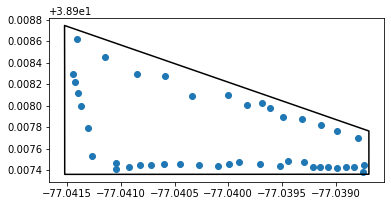

In [12]:
square_id = '0158'
#0196 - maybe break up multipolygons before?
one_square = squares[squares.loc[:,'SQUARE']==square_id].copy()
address_pts = addresses[addresses.loc[:,'SQUARE']==square_id].copy()

fig, ax = plt.subplots()
one_square.boundary.plot(ax=ax, edgecolor='black')
address_pts.plot(ax=ax)

In [40]:
address_pts_array = np.array([coords for coords in address_pts.geometry.apply(lambda x: (x.x,x.y))])

In [41]:
poly_shapes, pts, poly_to_pt_assignments  = voronoi_regions_from_coords(address_pts_array
                                                                        , one_square.unary_union)

poly_shapes_df = gpd.GeoDataFrame(pd.DataFrame(poly_to_pt_assignments,columns=['group']),
                        crs="EPSG:4326",
                        geometry=poly_shapes)

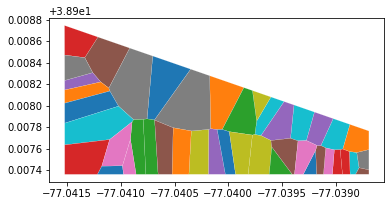

In [43]:
fig, ax = plt.subplots()
poly_shapes_df.plot(column='group', categorical=True, legend=False, linewidth=0.1, edgecolor='white', ax=ax)

In [56]:
poly_shapes_w_stname = gpd.sjoin(poly_shapes_df, address_pts[['SQUARE','SSL','STNAME','geometry']])

In [59]:
poly_shapes_dissolve_stname = poly_shapes_w_stname.dissolve(by='STNAME').reset_index()

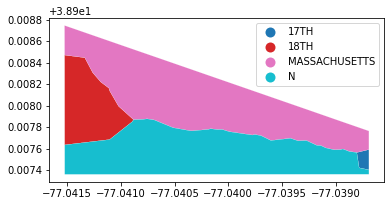

In [60]:
fig, ax = plt.subplots()
poly_shapes_dissolve_stname.plot(column='STNAME', categorical=True, legend=True, linewidth=0.1, edgecolor='white', ax=ax)

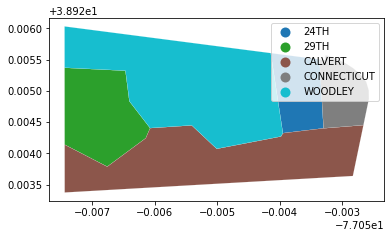

In [67]:
square_id = '2132'
fig, ax = plt.subplots()
poly_shapes_dissolve_stname = sb.split_on_poly_by_streetname(square_id)
poly_shapes_dissolve_stname.plot(column='STNAME', categorical=True, legend=True, linewidth=0.1, edgecolor='white', ax=ax)

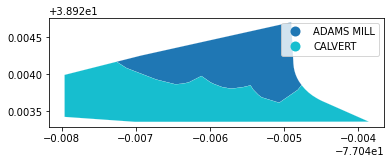

In [69]:
square_id = '2547'
fig, ax = plt.subplots()
poly_shapes_dissolve_stname = sb.split_on_poly_by_streetname(square_id)
poly_shapes_dissolve_stname.plot(column='STNAME', categorical=True, legend=True, linewidth=0.1, edgecolor='white', ax=ax)

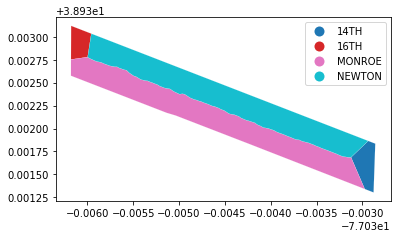

In [74]:
square_id = '2677'
fig, ax = plt.subplots()
poly_shapes_dissolve_stname = sb.split_on_poly_by_streetname(square_id)
poly_shapes_dissolve_stname.plot(column='STNAME', categorical=True, legend=True, linewidth=0.1, edgecolor='white', ax=ax)

In [75]:
poly_shapes_dissolve_stname

,STNAME,geometry,group,index_right,SQUARE,SSL,SQUARE_PART
0,14TH,"POLYGON ((-77.03297 38.93134, -77.03312 38.931...",68,92136,2677,2677 0712,1
1,16TH,"POLYGON ((-77.03600 38.93278, -77.03618 38.932...",15,22047,2677,2677 0811,1
2,MONROE,"POLYGON ((-77.03315 38.93169, -77.03312 38.931...",76,113686,2677,2677 0843,1
3,NEWTON,"POLYGON ((-77.03315 38.93169, -77.03322 38.931...",2,8290,2677,2677 0670,1


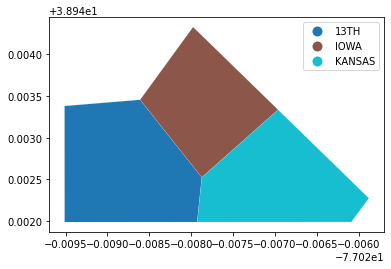

In [99]:
square_id = '2915'
fig, ax = plt.subplots()
poly_shapes_dissolve_stname = sb.split_on_poly_by_streetname(square_id)
poly_shapes_dissolve_stname.plot(column='STNAME', categorical=True, legend=True, linewidth=0.1, edgecolor='white', ax=ax)

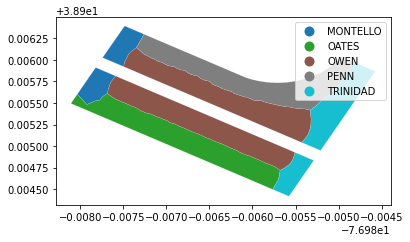

In [103]:
#try a bad shape - 4060
#try bad shape 2862
square_id = '4060'
fig, ax = plt.subplots()
poly_shapes_dissolve_stname = sb.split_on_poly_by_streetname(square_id)
poly_shapes_dissolve_stname.plot(column='STNAME', categorical=True, legend=True, linewidth=0.1, edgecolor='white', ax=ax)